### **Data Processing**
This file presents the data processing completed prior to the modeling phase

In [ ]:
# Import all the required libraries
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import ensemble
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Preprocessing
- Load the data and initial inspection
- Data cleaning
- Visuaization

### **1. Load the data**

In [ ]:
#Load the data
df_or=pd.read_csv('data_2022.csv')
df=df_or.copy()
df.shape
df_or.columns

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19536\783028131.py:2: DtypeWarning: Columns (2,3,28,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_or=pd.read_csv('data_2022.csv')


Index(['ID', 'Country', 'VFN', 'Mp', 'Mh', 'Man', 'MMS', 'Tan', 'T', 'Va',
       'Ve', 'Mk', 'Cn', 'Ct', 'Cr', 'r', 'm (kg)', 'Mt', 'Enedc (g/km)',
       'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ft', 'Fm',
       'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT', 'Ernedc (g/km)',
       'Erwltp (g/km)', 'De', 'Vf', 'Status', 'year', 'Date of registration',
       'Fuel consumption ', 'ech', 'RLFI', 'Electric range (km)'],
      dtype='object')

In [ ]:
del df_or

In [ ]:
new_column_names = [
    "ID", "Country", "Vehicle family identification number", "Pool", "Manufacturer name (EU standard)",
    "Manufacturer name (OEM declaration)", "Manufacturer name (MS registry denomination)", "Type approval number",
    "Type", "Variant", "Version", "Make", "Commercial name", "Category of the vehicle type approved",
    "Category of the vehicle registered", "Total new registrations", "Mass in running order (kg)", "WLTP test mass",
    "Specific CO2 Emissions in g/km (NEDC)", "Specific CO2 Emissions in g/km (WLTP)", "Wheel base in mm",
    "Axle width steering axle in mm", "Axle width other axle in mm", "Fuel type", "Fuel mode", "Engine capacity in cm3",
    "Engine power in KW", "Electric energy consumption in Wh/km", "Innovative technology",
    "Emissions reduction through IT in g/km", "Emissions reduction through IT in g/km (WLTP)",
    "Deviation factor", "Verification factor", "Type of data", "Registration year", "Date of registration",
    "Fuel consumption", "Character corresponding to the provisions used for the type-approval", "Roadload (Matrix) family’s",
    "Electric range (km)"
]

# Assign the new column names to your DataFrame
df.columns = new_column_names

# Display the updated DataFrame
df.head(2)

,ID,Country,Vehicle family identification number,Pool,Manufacturer name (EU standard),Manufacturer name (OEM declaration),Manufacturer name (MS registry denomination),Type approval number,Type,Variant,...,Emissions reduction through IT in g/km (WLTP),Deviation factor,Verification factor,Type of data,Registration year,Date of registration,Fuel consumption,Character corresponding to the provisions used for the type-approval,Roadload (Matrix) family’s,Electric range (km)
0,121150000,FR,IP-JDA1MTGJT4B_000-VF1-1,RENAULT-NISSAN-MITSUBISHI,RENAULT,RENAULT SAS,NaN,e2*2001/116*0323*72,SR,DHE2,...,1.7,NaN,NaN,P,2023,2023-03-27,7.8,Euro 6 AP,NaN,NaN
1,121150001,FR,IP-0093-JT1-1,SUBARU-SUZUKI-TOYOTA,TOYOTA,TOYOTA MOTOR EUROPE NV SA,NaN,e6*2007/46*0322*05,XV7(EUM),AXVH71(E),...,0.8,NaN,NaN,P,2023,2023-07-21,5.5,Euro 6 AP,NaN,NaN


### **2. Data cleaning**

<i> Remove purely electric cars  </i>

In [ ]:
#Remove purely electric cars because there's no direct CO2 emission
df[ 'Fuel type'].value_counts().sort_index()

Fuel type
DIESEL                  17
ELECTRIC                 1
LPG                      1
PETROL                  59
PETROL/ELECTRIC         28
diesel             1823152
diesel/electric      31135
e85                  46240
electric           1669456
hydrogen               730
lpg                 309717
ng                    7362
petrol             6014741
petrol/electric     832016
unknown                  1
Name: count, dtype: int64

<i> Pre-processing of the fuel type  </i>

In [ ]:
# Convert all values in the 'Fuel type' column to lowercase
df['Fuel type'] = df['Fuel type'].str.lower()

# Remove rows where 'Fuel type' is 'electric', 'unknown', 'hydrogen', or 'ng'
df = df[~df['Fuel type'].isin(['electric', 'unknown', 'hydrogen', 'ng'])]

# Verify the result
print(df['Fuel type'].value_counts().sort_index())

Fuel type
diesel             1823169
diesel/electric      31135
e85                  46240
lpg                 309718
petrol             6014800
petrol/electric     832044
Name: count, dtype: int64


<i> Pre-processing of the electric energy consumption in Wh/km </i>

In [ ]:
print(df['Electric energy consumption in Wh/km'].value_counts().sort_index())
print(df['Electric energy consumption in Wh/km'].isnull().sum())

#Replace the NaN in Eectric energy consumption

Electric energy consumption in Wh/km
11.0       1
12.0       2
17.0       1
18.0     778
20.0       2
        ... 
376.0     43
377.0     35
378.0      7
379.0      2
391.0      1
Name: count, Length: 326, dtype: int64
8292090


In [ ]:
# Filter rows where 'Electric energy consumption in Wh/km' is NaN
nan_rows = df[df['Electric energy consumption in Wh/km'].isna()]

# Check if the 'Fuel type' in those rows is one of the specified values
valid_fuel_types = ['diesel', 'e85', 'lpg', 'petrol']

# Total number of NaN rows
total_nan_rows = len(nan_rows)

# Number of NaN rows with valid fuel types
valid_fuel_type_count = nan_rows[nan_rows['Fuel type'].isin(valid_fuel_types)].shape[0]

# Percentage of NaN values that correspond to valid fuel types
percentage_valid_fuel_type = (valid_fuel_type_count / total_nan_rows) * 100

# Percentage of NaN values that do not correspond to valid fuel types
percentage_invalid_fuel_type = 100 - percentage_valid_fuel_type

# Print results
print(f"Percentage of NaN values in 'Electric energy consumption in Wh/km' corresponding to 'diesel', 'e85', 'lpg', or 'petrol': {percentage_valid_fuel_type:.2f}%")
print(f"Percentage of NaN values in 'Electric energy consumption in Wh/km' that do not correspond to those fuel types: {percentage_invalid_fuel_type:.2f}%")

Percentage of NaN values in 'Electric energy consumption in Wh/km' corresponding to 'diesel', 'e85', 'lpg', or 'petrol': 98.82%
Percentage of NaN values in 'Electric energy consumption in Wh/km' that do not correspond to those fuel types: 1.18%


In [ ]:
valid_fuel_types = ['diesel', 'e85', 'lpg', 'petrol']

# Remove rows where 'Electric energy consumption in Wh/km' is NaN and 'Fuel type' is not in valid_fuel_types
df_cleaned = df[~((df['Electric energy consumption in Wh/km'].isna()) & (~df['Fuel type'].isin(valid_fuel_types)))]

# Verify the result
print(f"Number of rows before cleaning: {df.shape[0]}")
print(f"Number of rows after cleaning: {df_cleaned.shape[0]}")

Number of rows before cleaning: 9057106
Number of rows after cleaning: 8958907


In [ ]:
# Replace NaN values in 'Electric energy consumption in Wh/km' with 0
df_cleaned['Electric energy consumption in Wh/km'] = df_cleaned['Electric energy consumption in Wh/km'].fillna(0)

# Verify the result
print(df_cleaned['Electric energy consumption in Wh/km'].isna().sum())  # Should print 0, indicating no NaNs are left

0


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16436\2035008590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Electric energy consumption in Wh/km'] = df_cleaned['Electric energy consumption in Wh/km'].fillna(0)


<i> Remove columns that are 50% empty </i>

In [ ]:
#Free memmory
df=df_cleaned
del df_cleaned

In [1]:
<i> Remove additional columns with a high share of NaNs </i>

SyntaxError: invalid syntax (<ipython-input-1-bebafda808b0>, line 1)

In [2]:
# Number of columns before dropping
columns_before = len(df.columns)

# Calculate the threshold for NaN values (25% of the total rows)
threshold = len(df) * 0.5

# Drop columns with more than 25% NaN values
df = df.dropna(axis=1, thresh=threshold)

# Number of columns after dropping
columns_after = len(df.columns)

columns_before, columns_after

NameError: name 'df' is not defined

<i> Complete basic statistics </i>

In [ ]:
df.describe()

,ID,Total new registrations,Mass in running order (kg),WLTP test mass,Specific CO2 Emissions in g/km (WLTP),Engine capacity in cm3,Engine power in KW,Electric energy consumption in Wh/km,Emissions reduction through IT in g/km (WLTP),Registration year,Fuel consumption
count,8.958907e+06,8958907.0,8.958602e+06,8.653373e+06,8.944155e+06,8.958725e+06,8.943281e+06,8.958907e+06,5.736416e+06,8958907.0,7.527711e+06
mean,1.263982e+08,1.0,1.478432e+03,1.596960e+03,1.268491e+02,1.542463e+03,1.053544e+02,1.539575e+01,1.525599e+00,2023.0,5.417351e+00
std,7.489112e+06,0.0,3.228152e+02,3.432812e+02,4.096197e+01,5.269465e+02,5.087773e+01,5.158660e+01,5.018350e-01,0.0,1.778156e+00
min,9.024041e+07,1.0,4.950000e+02,6.150000e+02,1.000000e+00,6.580000e+02,8.000000e+00,0.000000e+00,5.000000e-01,2023.0,1.000000e-01
25%,1.224634e+08,1.0,1.250000e+03,1.350000e+03,1.150000e+02,1.197000e+03,7.400000e+01,0.000000e+00,1.100000e+00,2023.0,4.900000e+00
50%,1.289475e+08,1.0,1.422000e+03,1.536000e+03,1.280000e+02,1.497000e+03,9.600000e+01,0.000000e+00,1.700000e+00,2023.0,5.500000e+00
75%,1.318440e+08,1.0,1.640000e+03,1.771000e+03,1.430000e+02,1.968000e+03,1.160000e+02,0.000000e+00,1.960000e+00,2023.0,6.100000e+00
max,1.347967e+08,1.0,4.953000e+03,4.574000e+03,5.430000e+02,7.997000e+03,1.177000e+03,3.910000e+02,7.000000e+00,2023.0,2.900000e+01


In [ ]:
df.columns

Index(['ID', 'Country', 'Vehicle family identification number', 'Pool',
       'Manufacturer name (EU standard)',
       'Manufacturer name (OEM declaration)', 'Type approval number', 'Type',
       'Variant', 'Version', 'Make', 'Commercial name',
       'Category of the vehicle type approved',
       'Category of the vehicle registered', 'Total new registrations',
       'Mass in running order (kg)', 'WLTP test mass',
       'Specific CO2 Emissions in g/km (WLTP)', 'Fuel type', 'Fuel mode',
       'Engine capacity in cm3', 'Engine power in KW',
       'Electric energy consumption in Wh/km', 'Innovative technology',
       'Emissions reduction through IT in g/km (WLTP)', 'Type of data',
       'Registration year', 'Date of registration', 'Fuel consumption'],
      dtype='object')

<i> Count the modalities of categorical variables </i>

In [ ]:
numerical_df=df.select_dtypes(include=['number'])
print(numerical_df.columns)
# Select categorical columns (including object and category types)
categorical_df = df.select_dtypes(include=['object', 'category'])
print(categorical_df.columns)

Index(['ID', 'Total new registrations', 'Mass in running order (kg)',
       'WLTP test mass', 'Specific CO2 Emissions in g/km (WLTP)',
       'Engine capacity in cm3', 'Engine power in KW',
       'Electric energy consumption in Wh/km',
       'Emissions reduction through IT in g/km (WLTP)', 'Registration year',
       'Fuel consumption'],
      dtype='object')
Index(['Country', 'Vehicle family identification number', 'Pool',
       'Manufacturer name (EU standard)',
       'Manufacturer name (OEM declaration)', 'Type approval number', 'Type',
       'Variant', 'Version', 'Make', 'Commercial name',
       'Category of the vehicle type approved',
       'Category of the vehicle registered', 'Fuel type', 'Fuel mode',
       'Innovative technology', 'Type of data', 'Date of registration'],
      dtype='object')


In [ ]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("\n")

Column: Country
['FR' 'ES' 'IT' 'DE' 'PL' 'BG' 'LU' 'PT' 'DK' 'MT' 'SK' 'IE' 'AT' 'RO'
 'CZ' 'SI' 'HU' 'SE' 'NL' 'NO' 'HR' 'FI' 'EE' 'LV' 'IS' 'LT' 'GR' 'BE'
 'CY']


Column: Vehicle family identification number
['IP-JDA1MTGJT4B_000-VF1-1' 'IP-0093-JT1-1' 'IP-HNS____ATN82444-VR3-0' ...
 'IP-0000372-WBA-1' '1P-23MB58PA6d_01-SC6-1' 'IP-0000925_UWBA']


Column: Pool
['RENAULT-NISSAN-MITSUBISHI' 'SUBARU-SUZUKI-TOYOTA' 'STELLANTIS' 'KIA'
 'VOLKSWAGEN' 'MERCEDES-BENZ AG' 'FORD' 'BMW' 'HYUNDAI MOTOR EUROPE' nan
 'MAZDA' 'KG MOBILITY GREAT WALL MOTOR']


Column: Manufacturer name (EU standard)
['RENAULT' 'TOYOTA' 'STELLANTIS AUTO' 'KIA SLOVAKIA' 'VOLKSWAGEN'
 'MERCEDES-BENZ AG' 'NISSAN AUTOMOTIVE EUROPE' 'FORD WERKE GMBH'
 'AUTOMOBILES PEUGEOT' 'SUZUKI MOTOR CORPORATION' 'KIA' 'BMW AG'
 'AUTOMOBILES CITROEN' 'TOYOTA MOTOR CORPORATION' 'DACIA' 'AUDI AG' 'SEAT'
 'OPEL AUTOMOBILE' 'HYUNDAI' 'STELLANTIS EUROPE' 'SKODA' 'VOLVO'
 'HYUNDAI CZECH' 'MAZDA EUROPE' 'HYUNDAI ASSAN' 'ALFA ROMEO'
 'JAGUAR L

In [3]:
# Set the Seaborn style to 'white' for a clean background without gridlines
sns.set_style("white")

# Calculate the absolute counts and percentages
country_counts = df['Country'].value_counts()
country_percentages = df['Country'].value_counts(normalize=True) * 100

# Create the figure and axis objects with higher DPI for better quality
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)

# Plot the absolute counts on the left y-axis
country_counts.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7, position=1, width=0.4)

# Set the labels and title for the left y-axis with custom fonts
ax1.set_ylabel('Absolute Counts', color='steelblue', fontsize=14)
ax1.set_xlabel('Country', fontsize=14)
ax1.set_title('Country Distribution: Absolute Counts and Percentages', fontsize=16, fontweight='bold')

# Create a second y-axis for the percentages
ax2 = ax1.twinx()

# Plot the percentages on the right y-axis
country_percentages.plot(kind='bar', ax=ax2, color='green', alpha=0.5, position=0, width=0.4)

# Set the labels for the right y-axis with custom fonts
ax2.set_ylabel('Percentage (%)', color='green', fontsize=14)

# Rotate x labels for better readability and set custom fonts
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add a legend
ax1.legend(['Absolute Counts'], loc='upper left')
ax2.legend(['Percentage (%)'], loc='upper right')

# Tighten layout for better spacing
plt.tight_layout()

# Save the plot as a high-resolution PNG image
plt.savefig('country_distribution.png', format='png', dpi=300)

# Display the plot
plt.show()

NameError: name 'sns' is not defined

In [ ]:
country_percentages = df['Country'].value_counts(normalize=True) * 100
print(country_percentages[:5])

Country
DE    24.957051
FR    17.632709
IT    16.370010
ES    10.255570
PL     5.093925
Name: proportion, dtype: float64


### Features engineering
- Select the features that really matter based on bibliography (Zubair et al. & Al-Nefaie et al.)

In [ ]:
# The selection of important features was done using using two articles we had access to
columns_to_use=['Country','Pool','Type','Commercial name', 'Mass in running order (kg)', 'WLTP test mass',
              'Specific CO2 Emissions in g/km (WLTP)', 'Fuel type', 'Fuel mode','Electric energy consumption in Wh/km','Engine power in KW',
               'Engine capacity in cm3',
               'Emissions reduction through IT in g/km (WLTP)',
               'Fuel consumption'
               ]


df_selected = df[columns_to_use]
df_selected.head()


,Country,Pool,Type,Commercial name,Mass in running order (kg),WLTP test mass,Specific CO2 Emissions in g/km (WLTP),Fuel type,Fuel mode,Electric energy consumption in Wh/km,Engine power in KW,Engine capacity in cm3,Emissions reduction through IT in g/km (WLTP),Fuel consumption
0,FR,RENAULT-NISSAN-MITSUBISHI,SR,DUSTER,1337.0,1446.0,126.0,lpg,B,0.0,74.0,999.0,1.70,7.8
1,FR,SUBARU-SUZUKI-TOYOTA,XV7(EUM),TOYOTA CAMRY,1670.0,1782.0,125.0,petrol,H,0.0,131.0,2487.0,0.80,5.5
3,FR,STELLANTIS,N,C5 X,1493.0,1576.0,135.0,petrol,M,0.0,96.0,1199.0,2.00,6.0
4,FR,KIA,NQ5E,SPORTAGE,1649.0,1814.0,131.0,petrol,H,0.0,132.0,1598.0,0.59,5.8
5,FR,SUBARU-SUZUKI-TOYOTA,AX1T(EUM),TOYOTA C-HR,1560.0,1640.0,118.0,petrol,H,0.0,112.0,1987.0,0.80,5.2


In [ ]:
columns_to_use = ['Country', 'Pool', 'Manufacturer name (EU standard)', 'Type', 'Commercial name',
                  'Mass in running order (kg)', 'WLTP test mass', 'Specific CO2 Emissions in g/km (WLTP)',
                  'Fuel type', 'Fuel mode', 'Engine capacity in cm3', 'Electric energy consumption in Wh/km','Engine power in KW',
                  'Emissions reduction through IT in g/km (WLTP)', 'Fuel consumption']

df_selected = df[columns_to_use]

# Get the data types of the selected columns
column_types = df_selected.dtypes

# Display the data types
print(column_types)

Country                                           object
Pool                                              object
Manufacturer name (EU standard)                   object
Type                                              object
Commercial name                                   object
Mass in running order (kg)                       float64
WLTP test mass                                   float64
Specific CO2 Emissions in g/km (WLTP)            float64
Fuel type                                         object
Fuel mode                                         object
Engine capacity in cm3                           float64
Electric energy consumption in Wh/km             float64
Engine power in KW                               float64
Emissions reduction through IT in g/km (WLTP)    float64
Fuel consumption                                 float64
dtype: object


In [ ]:
df_selected.isna().mean()*100

Country                                           0.000000
Pool                                              4.905353
Manufacturer name (EU standard)                   0.000000
Type                                              0.064818
Commercial name                                   0.002523
Mass in running order (kg)                        0.003404
WLTP test mass                                    3.410394
Specific CO2 Emissions in g/km (WLTP)             0.164663
Fuel type                                         0.000000
Fuel mode                                         0.000000
Engine capacity in cm3                            0.002031
Electric energy consumption in Wh/km              0.000000
Engine power in KW                                0.174419
Emissions reduction through IT in g/km (WLTP)    35.969689
Fuel consumption                                 15.975118
dtype: float64

In [ ]:
columns=['Fuel consumption','Specific CO2 Emissions in g/km (WLTP)','WLTP test mass','Pool','Mass in running order (kg)','Commercial name', 'Engine capacity in cm3','Type','Engine power in KW']
df_selected= df_selected.dropna(subset=columns)

In [ ]:
df_selected['Emissions reduction through IT in g/km (WLTP)'].fillna(0,inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16436\1471528708.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_selected['Emissions reduction through IT in g/km (WLTP)'].fillna(0,inplace=True)


In [ ]:
df_selected.isna().mean()*100
print(len(df_selected))

7047745


In [ ]:
# Initialize an empty dictionary to store the ranges
column_ranges = {}

# Iterate over each column and calculate the range
for column in df_selected.columns:
    if pd.api.types.is_numeric_dtype(df_selected[column]):
        # For numerical columns, calculate the range
        column_ranges[column] = {
            'min': df_selected[column].min(),
            'max': df_selected[column].max()
        }
    else:
        # For non-numerical columns, show the unique values as their "range"
        column_ranges[column] = {
            'unique_values': df_selected[column].unique()
        }

# Convert the dictionary to a DataFrame for better readability
column_ranges_df = pd.DataFrame(column_ranges).T

# Display the ranges
print(column_ranges_df)

                                                                                   unique_values  \
Country                                        [FR, ES, IT, DE, PL, BG, LU, PT, MT, SK, IE, A...   
Pool                                           [RENAULT-NISSAN-MITSUBISHI, SUBARU-SUZUKI-TOYO...   
Manufacturer name (EU standard)                [RENAULT, TOYOTA, STELLANTIS AUTO, KIA SLOVAKI...   
Type                                           [SR, XV7(EUM), N, NQ5E, AX1T(EUM), C1, F2B, F1...   
Commercial name                                [DUSTER, TOYOTA CAMRY, C5 X, SPORTAGE, TOYOTA ...   
Mass in running order (kg)                                                                   NaN   
WLTP test mass                                                                               NaN   
Specific CO2 Emissions in g/km (WLTP)                                                        NaN   
Fuel type                                      [lpg, petrol, diesel, e85, petrol/electric, di...   


In [ ]:
del df
del df_or

NameError: name 'df_or' is not defined

### **2. Data Visualization**
- Box plot to identify the distribution of the data
- Plot of the correlation machine

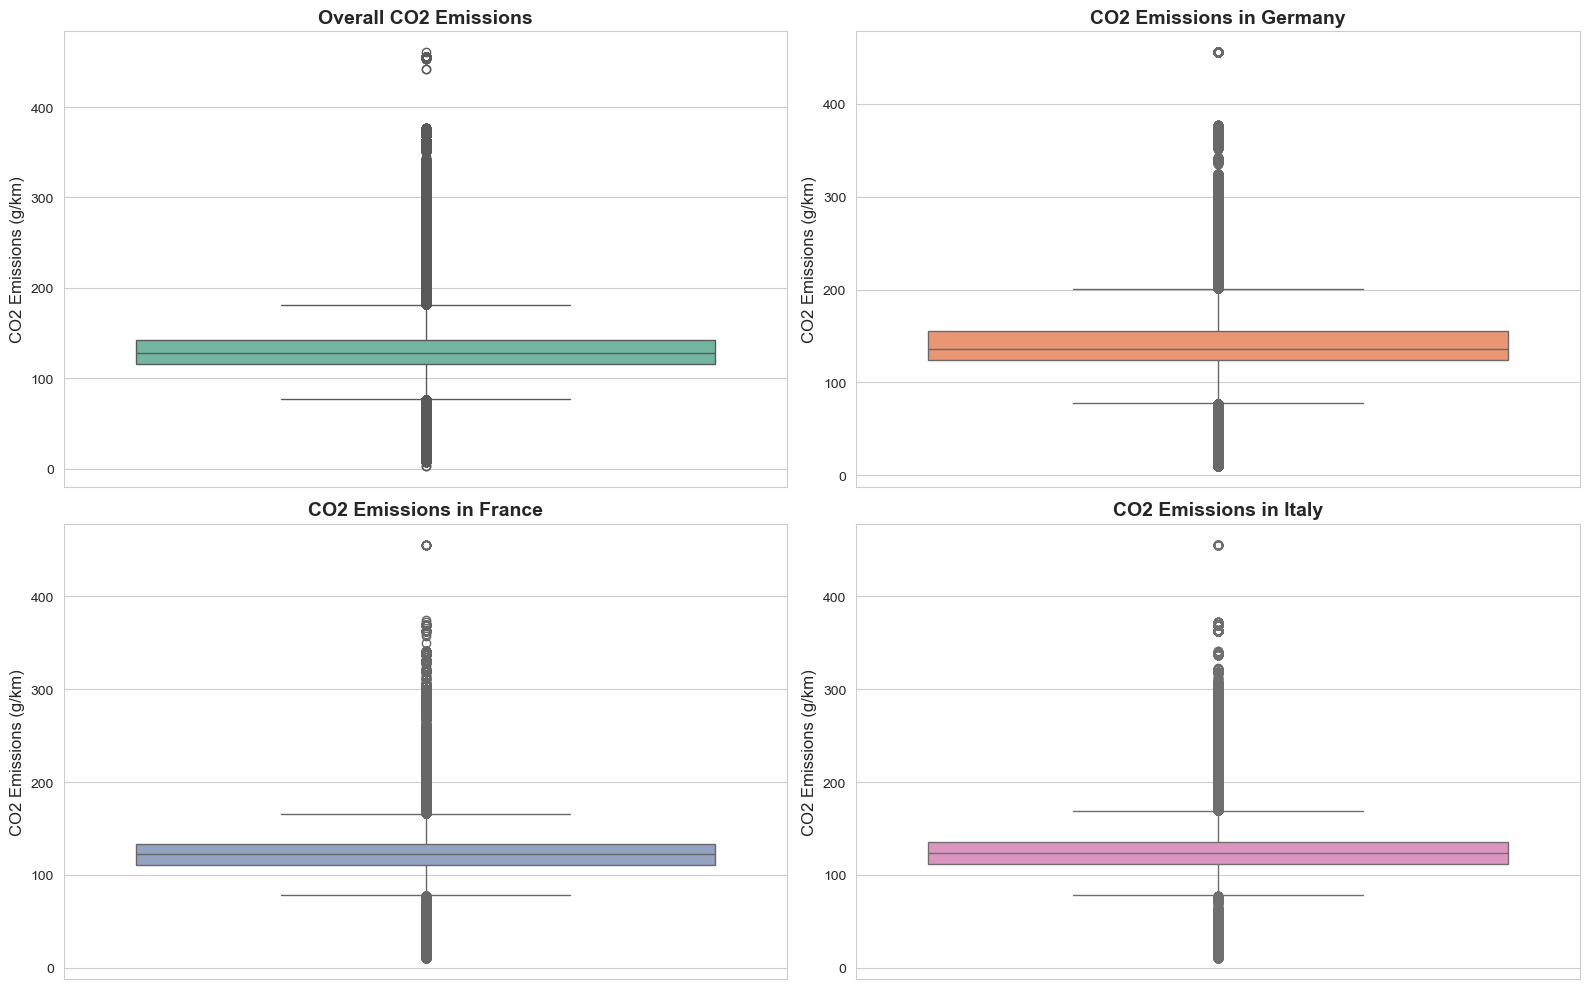

In [ ]:
# Set the Seaborn style for better aesthetics
sns.set_style("whitegrid")

# Define a color palette
palette = sns.color_palette("Set2")

# Define the figure size and layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Helper function to plot boxplots with enhancements
def plot_boxplot(data, title, ax, color):
    sns.boxplot(y='Specific CO2 Emissions in g/km (WLTP)', data=data, ax=ax, color=color)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('CO2 Emissions (g/km)', fontsize=12)
    ax.set_xlabel('')  # Remove the x-axis label as it's not needed

# Plot for the overall dataset
plot_boxplot(df_selected, 'Overall CO2 Emissions', axes[0, 0], palette[0])

# Plot for Germany
plot_boxplot(df_selected[df_selected['Country'] == 'DE'], 'CO2 Emissions in Germany', axes[0, 1], palette[1])

# Plot for France
plot_boxplot(df_selected[df_selected['Country'] == 'FR'], 'CO2 Emissions in France', axes[1, 0], palette[2])

# Plot for Italy
plot_boxplot(df_selected[df_selected['Country'] == 'IT'], 'CO2 Emissions in Italy', axes[1, 1], palette[3])

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a high-resolution PNG image for inclusion in a report
plt.savefig('co2_emissions_report.png', format='png', dpi=300)

# Show the plots
plt.show()

In [4]:
# Set the Seaborn style to 'white' for a clean background without gridlines
sns.set_style("white")

# Function to trim labels to a maximum of 7 characters
def trim_labels(labels):
    return [label[:7] for label in labels]

# Determine the unique pools and their trimmed versions in the desired order
ordered_pools = df_selected['Pool'].unique()
ordered_pools_sorted = sorted(ordered_pools, key=lambda x: x[:5])  # Sort by trimmed label
ordered_pools_trimmed = trim_labels(ordered_pools_sorted)

# Define the figure size and layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Helper function to plot boxplots only if data exists
def plot_if_data_exists(data, title, ax):
    if not data.empty:
        # Reorder the pools in the same order for all plots
        data['Pool'] = pd.Categorical(data['Pool'], categories=ordered_pools_sorted, ordered=True)
        sns.boxplot(x='Pool', y='Specific CO2 Emissions in g/km (WLTP)', data=data, ax=ax)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Pool', fontsize=12)
        ax.set_ylabel('CO2 Emissions (g/km)', fontsize=12)
        ax.set_xticks(range(len(ordered_pools_trimmed)))
        ax.set_xticklabels(ordered_pools_trimmed, rotation=45, ha='right', fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Overall data box plot
plot_if_data_exists(df_selected, 'Overall CO2 Emissions by Pool', axes[0, 0])

# Germany box plot
plot_if_data_exists(df_selected[df_selected['Country'] == 'DE'], 'CO2 Emissions by Pool in Germany', axes[0, 1])

# France box plot
plot_if_data_exists(df_selected[df_selected['Country'] == 'FR'], 'CO2 Emissions by Pool in France', axes[1, 0])

# Remove the last subplot (which was for Italy)
fig.delaxes(axes[1, 1])

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a high-resolution PNG image for inclusion in a report
plt.savefig('co2_emissions_report_no_grid_no_italy.png', format='png', dpi=300)

# Show the plots
plt.show()

NameError: name 'sns' is not defined

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16436\3010560202.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Pool', y='Specific CO2 Emissions in g/km (WLTP)', data=data, ax=ax, ci=None)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16436\3010560202.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Pool'] = pd.Categorical(data['Pool'], categories=ordered_pools_sorted, ordered=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16436\3010560202.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Pool', y='Specific CO2 Emissions in g/km (WLTP)', data=data, ax=ax, ci=None)
C:\Users\Lenovo\AppData\Local\Temp\ipy

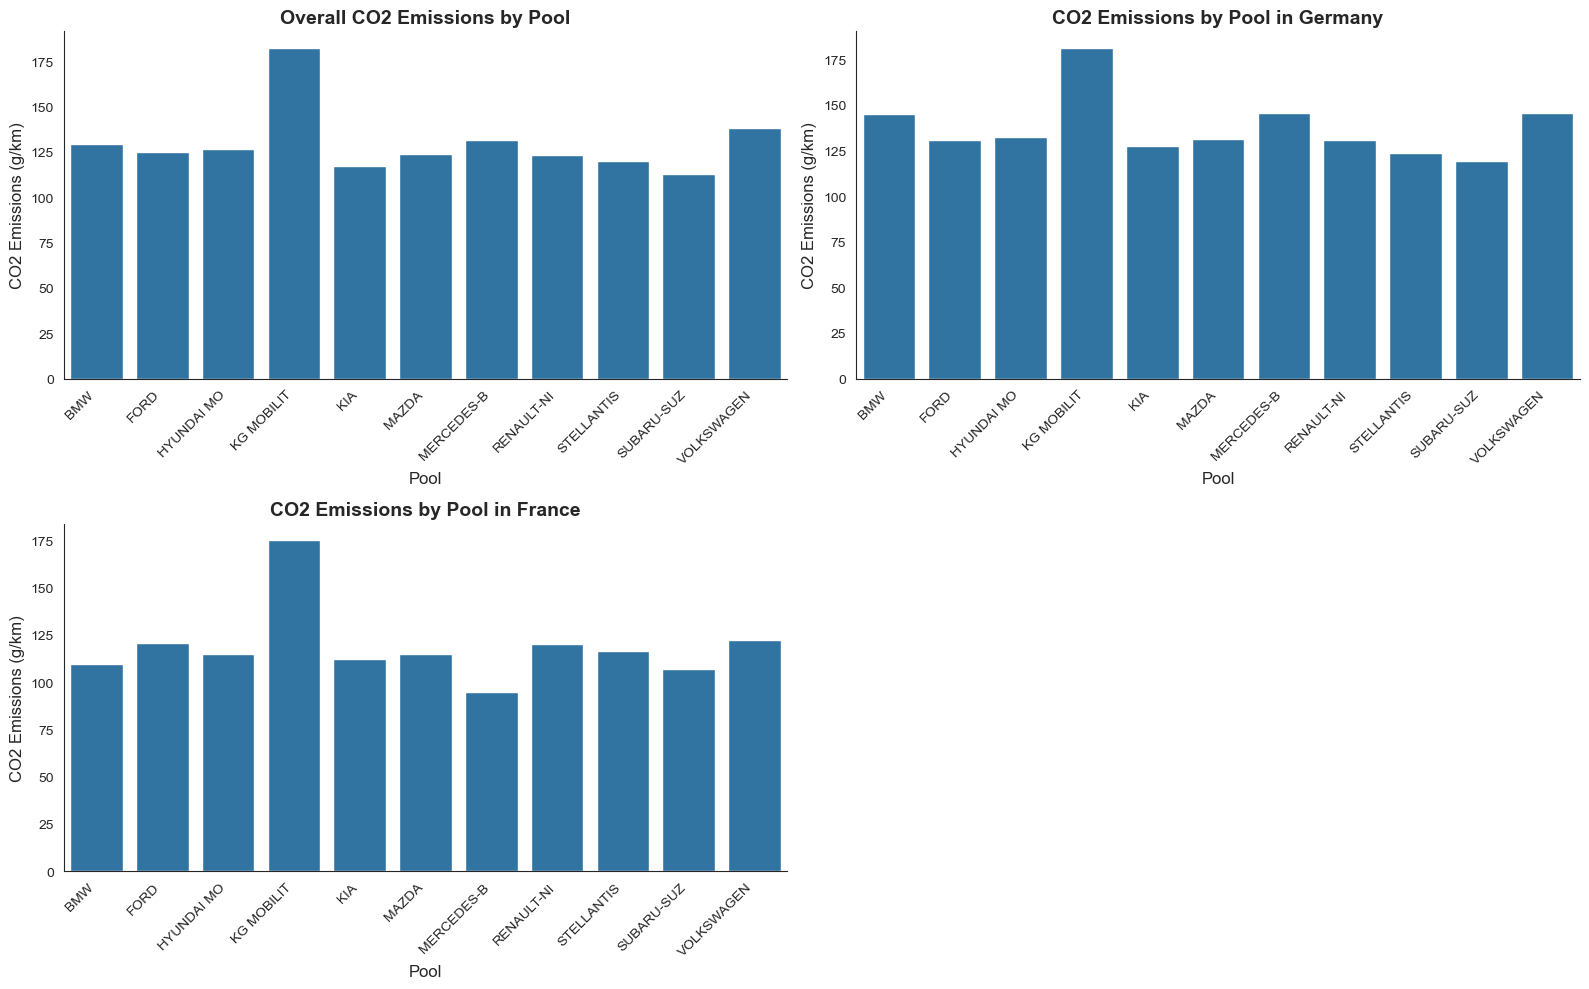

In [ ]:
# Set the Seaborn style to 'white' for a clean background without gridlines
sns.set_style("white")

# Function to trim labels to a maximum of 7 characters
def trim_labels(labels):
    return [label[:10] for label in labels]

# Determine the unique pools and their trimmed versions in the desired order
ordered_pools = df_selected['Pool'].unique()
ordered_pools_sorted = sorted(ordered_pools, key=lambda x: x[:5])  # Sort by trimmed label
ordered_pools_trimmed = trim_labels(ordered_pools_sorted)

# Define the figure size and layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Helper function to plot bar plots only if data exists
def plot_if_data_exists(data, title, ax):
    if not data.empty:
        # Reorder the pools in the same order for all plots
        data['Pool'] = pd.Categorical(data['Pool'], categories=ordered_pools_sorted, ordered=True)
        sns.barplot(x='Pool', y='Specific CO2 Emissions in g/km (WLTP)', data=data, ax=ax, ci=None)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Pool', fontsize=12)
        ax.set_ylabel('CO2 Emissions (g/km)', fontsize=12)
        ax.set_xticks(range(len(ordered_pools_trimmed)))
        ax.set_xticklabels(ordered_pools_trimmed, rotation=45, ha='right', fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Overall data bar plot
plot_if_data_exists(df_selected, 'Overall CO2 Emissions by Pool', axes[0, 0])

# Germany bar plot
plot_if_data_exists(df_selected[df_selected['Country'] == 'DE'], 'CO2 Emissions by Pool in Germany', axes[0, 1])

# France bar plot
plot_if_data_exists(df_selected[df_selected['Country'] == 'FR'], 'CO2 Emissions by Pool in France', axes[1, 0])

# Remove the last subplot (which was for Italy)
fig.delaxes(axes[1, 1])

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a high-resolution PNG image for inclusion in a report
plt.savefig('co2_emissions_report_no_grid_no_italy.png', format='png', dpi=300)

# Show the plots
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16436\3010560202.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Pool', y='Specific CO2 Emissions in g/km (WLTP)', data=data, ax=ax, ci=None)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16436\3010560202.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Pool'] = pd.Categorical(data['Pool'], categories=ordered_pools_sorted, ordered=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16436\3010560202.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Pool', y='Specific CO2 Emissions in g/km (WLTP)', data=data, ax=ax, ci=None)
C:\Users\Lenovo\AppData\Local\Temp\ipy

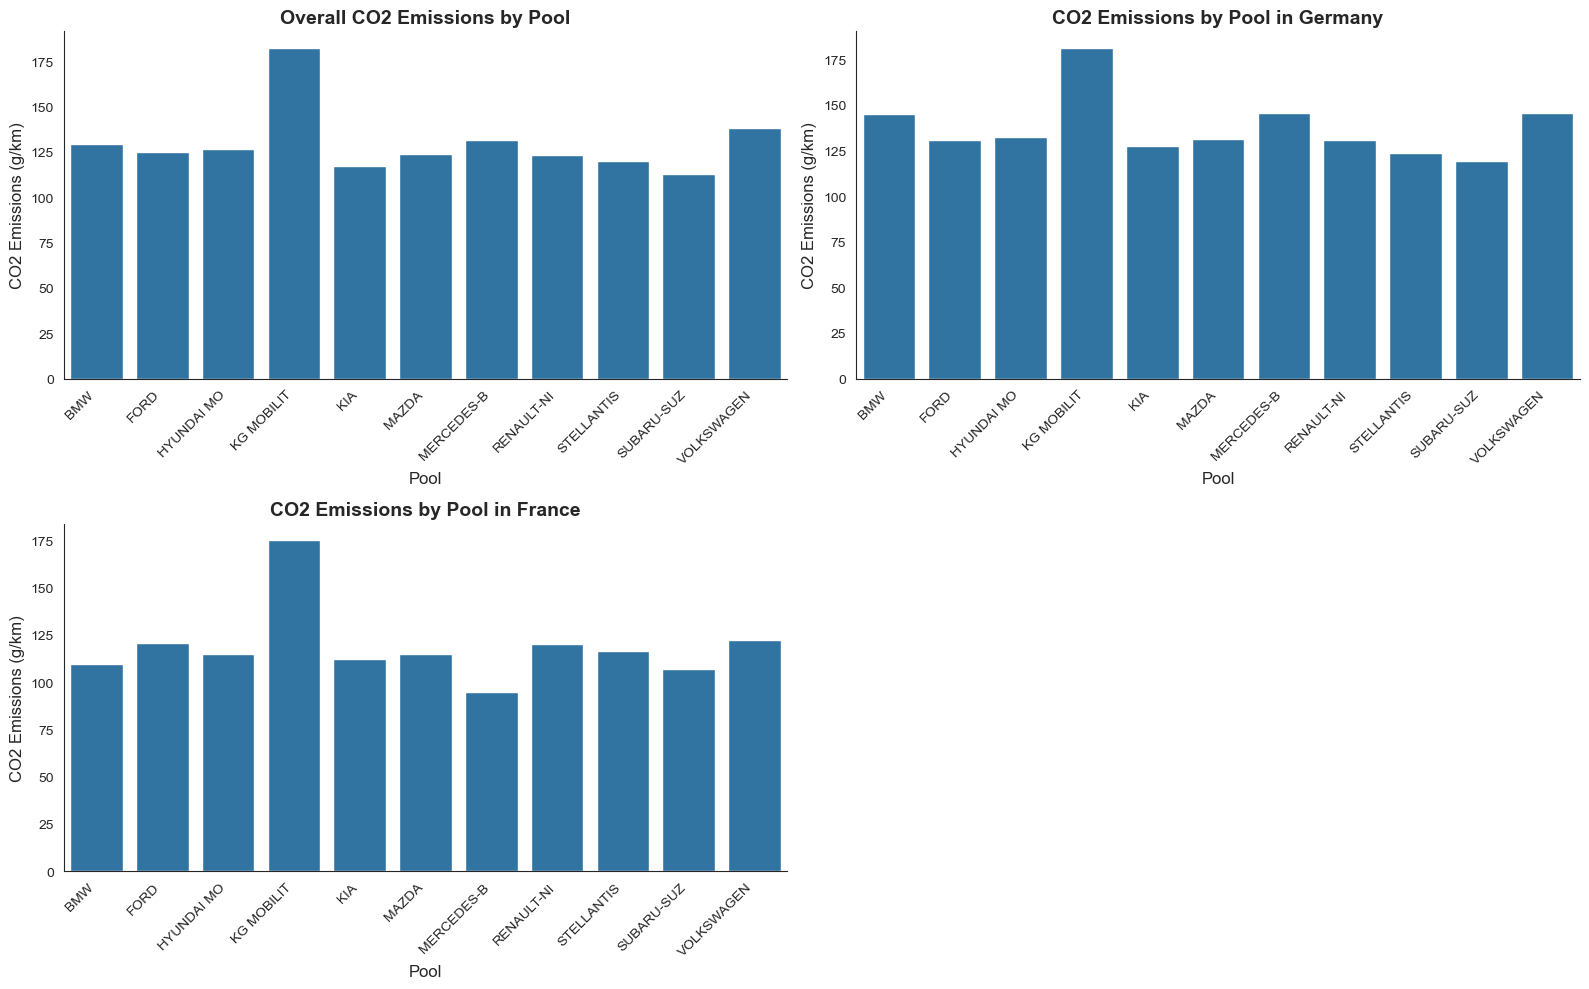

In [ ]:
# Set the Seaborn style to 'white' for a clean background without gridlines
sns.set_style("white")

# Function to trim labels to a maximum of 7 characters
def trim_labels(labels):
    return [label[:10] for label in labels]

# Determine the unique pools and their trimmed versions in the desired order
ordered_pools = df_selected['Pool'].unique()
ordered_pools_sorted = sorted(ordered_pools, key=lambda x: x[:5])  # Sort by trimmed label
ordered_pools_trimmed = trim_labels(ordered_pools_sorted)

# Define the figure size and layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Helper function to plot bar plots only if data exists
def plot_if_data_exists(data, title, ax):
    if not data.empty:
        # Reorder the pools in the same order for all plots
        data['Pool'] = pd.Categorical(data['Pool'], categories=ordered_pools_sorted, ordered=True)
        sns.barplot(x='Pool', y='Specific CO2 Emissions in g/km (WLTP)', data=data, ax=ax, ci=None)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Pool', fontsize=12)
        ax.set_ylabel('CO2 Emissions (g/km)', fontsize=12)
        ax.set_xticks(range(len(ordered_pools_trimmed)))
        ax.set_xticklabels(ordered_pools_trimmed, rotation=45, ha='right', fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Overall data bar plot
plot_if_data_exists(df_selected, 'Overall CO2 Emissions by Pool', axes[0, 0])

# Germany bar plot
plot_if_data_exists(df_selected[df_selected['Country'] == 'DE'], 'CO2 Emissions by Pool in Germany', axes[0, 1])

# France bar plot
plot_if_data_exists(df_selected[df_selected['Country'] == 'FR'], 'CO2 Emissions by Pool in France', axes[1, 0])

# Remove the last subplot (which was for Italy)
fig.delaxes(axes[1, 1])

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a high-resolution PNG image for inclusion in a report
plt.savefig('co2_emissions_report_no_grid_no_italy.png', format='png', dpi=300)

# Show the plots
plt.show()

In [ ]:
# Create a function to generate summary statistics for a specific subset of the data
def generate_statistics(data, country_name):
    stats = data['Specific CO2 Emissions in g/km (WLTP)'].describe().to_frame().T
    stats['Country'] = country_name
    return stats

# Get statistics for the overall dataset
overall_stats = generate_statistics(df_selected, 'Overall')

# Get statistics for Germany
germany_stats = generate_statistics(df_selected[df_selected['Country'] == 'DE'], 'Germany')

# Get statistics for France
france_stats = generate_statistics(df_selected[df_selected['Country'] == 'FR'], 'France')

# Get statistics for Italy
italy_stats = generate_statistics(df_selected[df_selected['Country'] == 'IT'], 'Italy')

# Concatenate all the statistics into one DataFrame
all_stats = pd.concat([overall_stats, germany_stats, france_stats, italy_stats])

# Reset index for better display
all_stats.reset_index(drop=True, inplace=True)

# Display the statistics table
print(all_stats)

       count        mean        std   min    25%    50%    75%    max  Country
0  7047745.0  126.869306  39.657309   3.0  116.0  128.0  142.0  461.0  Overall
1  2138800.0  139.018254  45.447128  10.0  124.0  136.0  155.0  456.0  Germany
2  1543582.0  116.503732  32.390576  10.0  111.0  122.0  133.0  456.0   France
3  1358158.0  125.472290  25.300384  10.0  112.0  124.0  135.0  456.0    Italy


In [ ]:
print('The stastics of data from Italy is close to the overall data', 'We can just keep 3 data sets: All,Germany, France, Italy')

The stastics of data from Italy is close to the overall data We can just keep 3 data sets: All,Germany, France, Italy


- Correlation between several variables

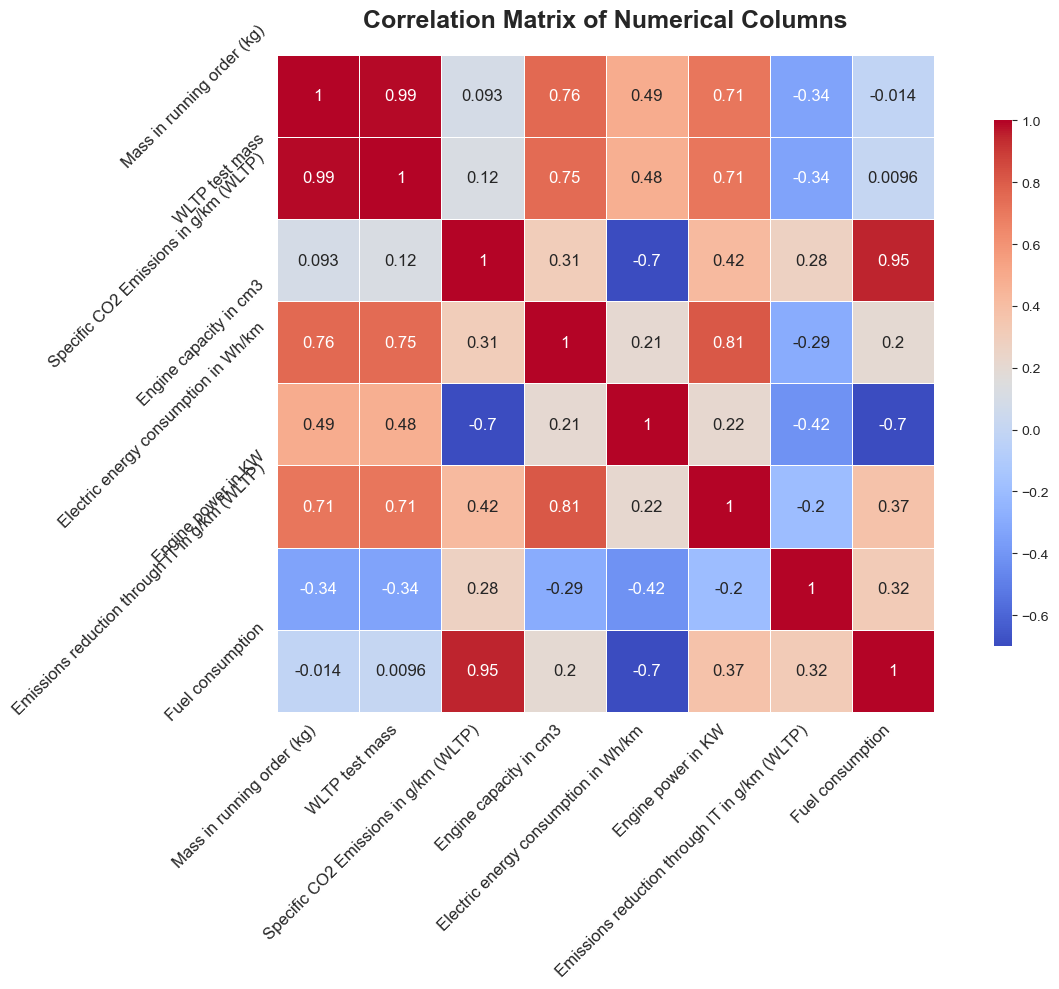

In [ ]:
# Select only numerical columns
numerical_df = df_selected.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the heatmap with enhanced aesthetics
plt.figure(figsize=(14, 10))  # Larger figure size for better readability
heatmap = sns.heatmap(correlation_matrix,
                      annot=True,             # Show the correlation values
                      cmap='coolwarm',        # Color map
                      linewidths=0.5,         # Add lines between squares
                      annot_kws={"size": 12}, # Adjust the font size of annotations
                      cbar_kws={"shrink": 0.8, "aspect": 30}, # Adjust the colorbar
                      square=True)            # Keep the squares square-shaped

# Rotate the x and y axis labels to 45 degrees
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=45, fontsize=12)

# Title with a bigger font size and bold
plt.title('Correlation Matrix of Numerical Columns', fontsize=18, fontweight='bold', pad=20)

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout()

# Save the plot as a high-resolution PNG image
plt.savefig('correlation_matrix_report.png', format='png', dpi=300)

# Show the plot
plt.show()

In [ ]:
#Final list of the columns to use
columns_to_use=['Mass in running order (kg)', 'WLTP test mass',
       'Specific CO2 Emissions in g/km (WLTP)', 'Engine capacity in cm3',
       'Emissions reduction through IT in g/km (WLTP)', 'Fuel consumption','Fuel type','Electric energy consumption in Wh/km','Engine power in KW'
               ]

In [ ]:
df_selected = df_selected[columns_to_use]

In [ ]:
numerical_df.columns

Index(['Mass in running order (kg)', 'WLTP test mass',
       'Specific CO2 Emissions in g/km (WLTP)', 'Engine capacity in cm3',
       'Electric energy consumption in Wh/km', 'Engine power in KW',
       'Emissions reduction through IT in g/km (WLTP)', 'Fuel consumption'],
      dtype='object')

In [ ]:
# Save DataFrame to CSV
df_selected.to_csv('numerical_data_2022.csv', index=False)